In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from xgboost import XGBRegressor
from sklearn.svm import SVR
import h2o
from h2o.automl import H2OAutoML
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Set scientific notation for numerical outputs
np.set_printoptions(formatter={'float': '{:0.2e}'.format})

# Load the dataset
data = pd.read_csv('Final Average Price of stocks And Houses.csv')

data

,Date,FTSE 100,Average_Price
0,2-Jan-13,"6,347.24",271269.77
1,3-Jan-13,"6,378.60",332742.58
2,5-Jan-13,"6,451.29",465652.10
3,7-Jan-13,"6,307.78",344718.61
4,8-Jan-13,"6,681.98",231381.07
...,...,...,...
124,6-Dec-17,"7,511.87",479772.29
125,7-Dec-17,"7,416.93",802128.85
126,9-Dec-17,"7,400.69",479541.31
127,10-Dec-17,"7,556.24",871725.83


In [4]:
data.shape
# data is the dataframe object name whose dimension we want to obtain

(129, 3)

In [5]:
# Check data types first
print(data.dtypes)

Date              object
FTSE 100          object
Average_Price    float64
dtype: object


In [7]:
# Check and rename columns if necessary
print(data.columns)

# Convert data types and parse dates
# Assuming columns were named differently, rename them
data.columns = ['Date', 'Stock_Price', 'Average_House_Price']  # Adjust to your actual dataset

# Ensure Stock_Price and Average_House_Price are floats, replace commas if needed
if data['Stock_Price'].dtype == 'object':
    data['Stock_Price'] = data['Stock_Price'].str.replace(',', '').astype(float)

if data['Average_House_Price'].dtype == 'object':
    data['Average_House_Price'] = data['Average_House_Price'].str.replace(',', '').astype(float)

# Descriptive statistics
descriptive_stats_new = data[['Stock_Price', 'Average_House_Price']].describe()
print("Descriptive Statistics:\n", descriptive_stats_new)


Index(['Date', 'Stock_Price', 'Average_House_Price'], dtype='object')
Descriptive Statistics:
        Stock_Price  Average_House_Price
count   129.000000         1.290000e+02
mean   6632.003721         5.063595e+05
std     464.382111         2.110953e+05
min    5536.970000         2.313811e+05
25%    6300.630000         3.860392e+05
50%    6659.040000         4.574656e+05
75%    6871.800000         5.125806e+05
max    7556.240000         1.350726e+06


In [8]:
# Step 1: Handle Missing Values
print("Checking for missing values:")
print(data.isnull().sum())

Checking for missing values:
Date                   0
Stock_Price            0
Average_House_Price    0
dtype: int64


In [9]:
# Impute missing values with the median
data['Stock_Price'].fillna(data['Stock_Price'].median(), inplace=True)
data['Average_House_Price'].fillna(data['Average_House_Price'].median(), inplace=True)

# Verify no missing values remain
print("After imputation, missing values:")
print(data.isnull().sum())


After imputation, missing values:
Date                   0
Stock_Price            0
Average_House_Price    0
dtype: int64


In [10]:
# Step 2: Detect and Remove Outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


Dataset size after removing outliers: (107, 3)


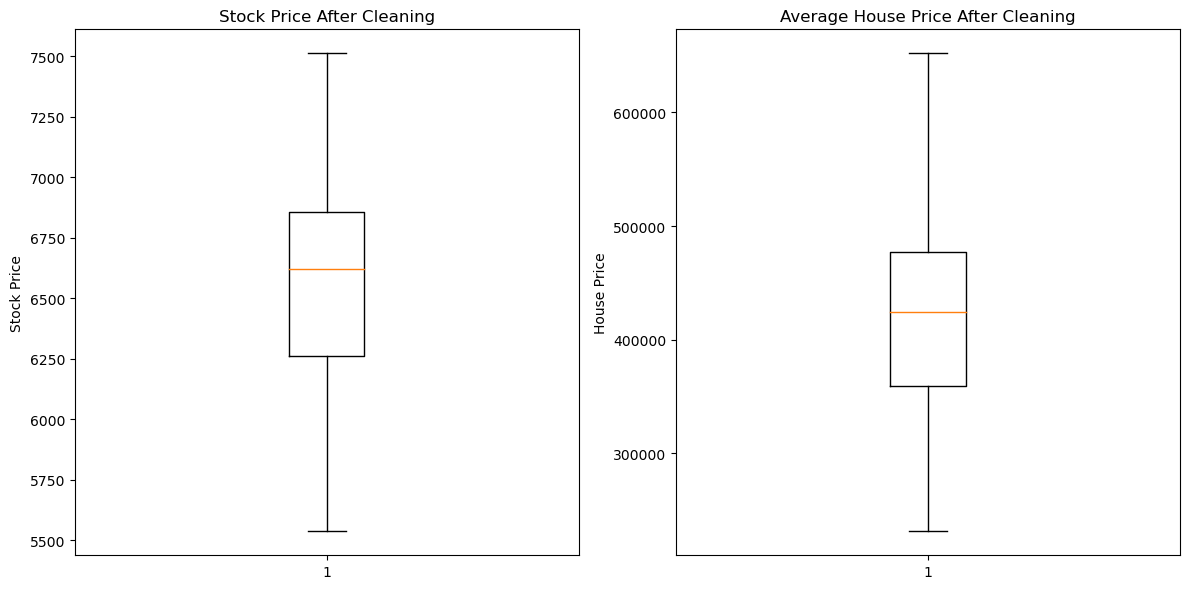

Summary statistics after data cleaning:
       Stock_Price  Average_House_Price
count   107.000000           107.000000
mean   6598.636168        426316.498692
std     464.195483         84975.448341
min    5536.970000        231381.070000
25%    6262.575000        359535.990000
50%    6620.900000        424183.450000
75%    6855.885000        477565.370000
max    7511.870000        651985.580000


In [12]:
# Apply outlier removal for both Stock Price and Average House Price
data = remove_outliers(data, 'Stock_Price')
data = remove_outliers(data, 'Average_House_Price')

# Verify the size of the dataset after outlier removal
print(f"Dataset size after removing outliers: {data.shape}")

# Step 3: Visualize to Confirm Data Cleaning
# Boxplots before and after cleaning
plt.figure(figsize=(12, 6))

# Stock Price
plt.subplot(1, 2, 1)
plt.boxplot(data['Stock_Price'])
plt.title('Stock Price After Cleaning')
plt.ylabel('Stock Price')

# Average House Price
plt.subplot(1, 2, 2)
plt.boxplot(data['Average_House_Price'])
plt.title('Average House Price After Cleaning')
plt.ylabel('House Price')

plt.tight_layout()
plt.show()

# Summary statistics after cleaning
print("Summary statistics after data cleaning:")
print(data.describe())


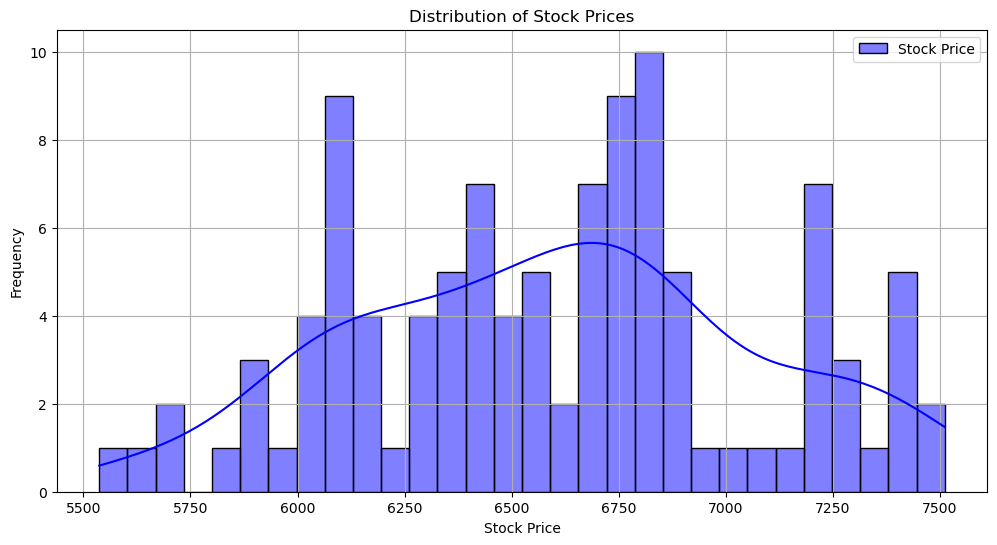

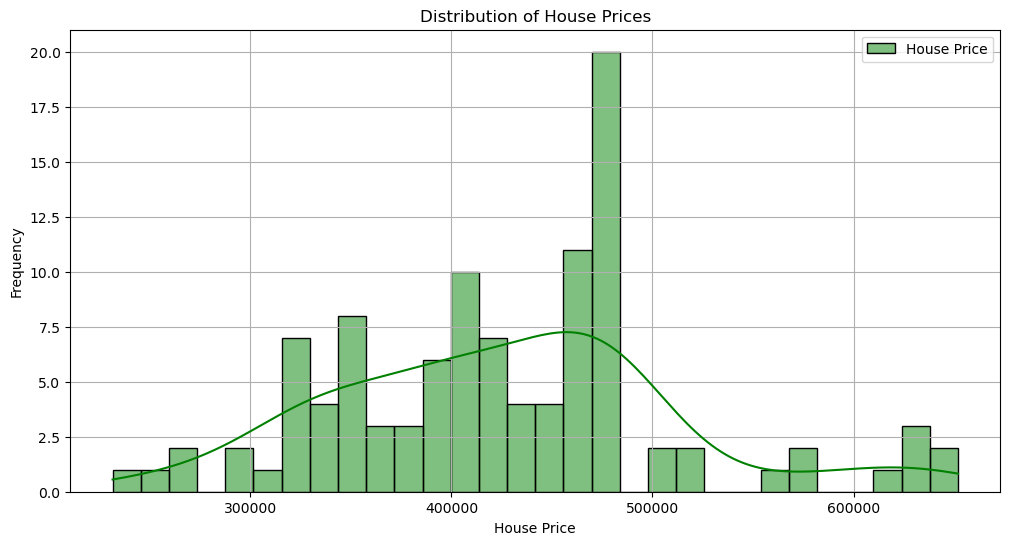

In [13]:
# Visualization of Distributions
plt.figure(figsize=(12, 6))
sns.histplot(data['Stock_Price'], kde=True, bins=30, color='blue', label='Stock Price')
plt.title('Distribution of Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['Average_House_Price'], kde=True, bins=30, color='green', label='House Price')
plt.title('Distribution of House Prices')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Split the dataset into training and testing sets
X = data[['Stock_Price']]
y = data['Average_House_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features for advanced models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Import necessary metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression Metrics: MSE={mse_linear:.2e}, RMSE={rmse_linear:.2e}, MAE={mae_linear:.2e}, R^2={r2_linear:.2f}")



Linear Regression Metrics: MSE=1.56e+10, RMSE=1.25e+05, MAE=1.03e+05, R^2=-0.06


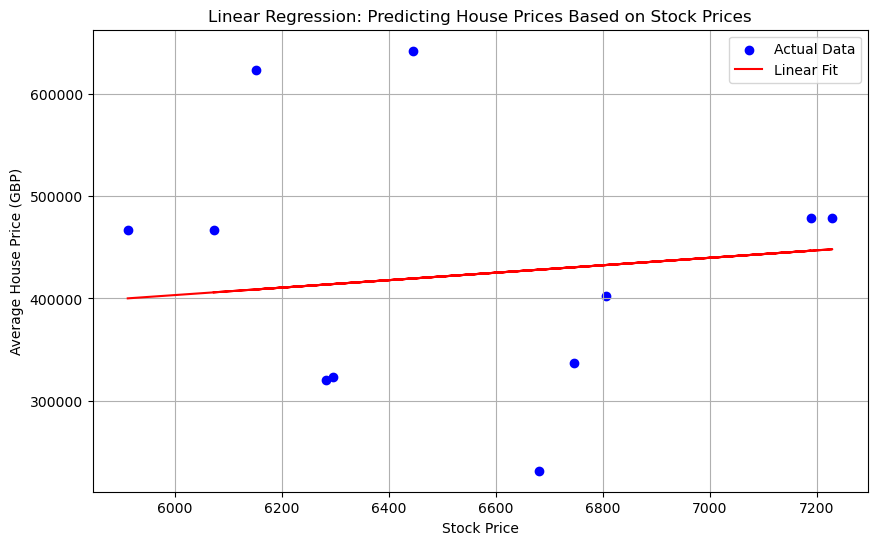

In [16]:
# Visualize Linear Regression Results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, y_pred_linear, color='red', label='Linear Fit')
plt.title('Linear Regression: Predicting House Prices Based on Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Average House Price (GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Split the data into training and testing sets (80-20 split)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    data[['Stock_Price']], data['Average_House_Price'], test_size=0.2, random_state=42
)

# Create polynomial features of degree 2
poly = PolynomialFeatures(degree=2)
X_train_poly_features = poly.fit_transform(X_train_poly)
X_test_poly_features = poly.transform(X_test_poly)

# Train a linear regression model on the polynomial features
poly_model = LinearRegression()
poly_model.fit(X_train_poly_features, y_train_poly)

# Make predictions
y_train_pred_poly = poly_model.predict(X_train_poly_features)
y_test_pred_poly = poly_model.predict(X_test_poly_features)

# Evaluate the model
mse_poly_train = mean_squared_error(y_train_poly, y_train_pred_poly)
mse_poly_test = mean_squared_error(y_test_poly, y_test_pred_poly)
r2_poly_train = r2_score(y_train_poly, y_train_pred_poly)
r2_poly_test = r2_score(y_test_poly, y_test_pred_poly)

# Print the evaluation metrics
print("Polynomial Regression (Degree 2):")
print(f"Training MSE: {mse_poly_train:.2e}, Training R^2: {r2_poly_train:.2f}")
print(f"Testing MSE: {mse_poly_test:.2e}, Testing R^2: {r2_poly_test:.2f}")


Polynomial Regression (Degree 2):
Training MSE: 5.82e+09, Training R^2: 0.10
Testing MSE: 9.45e+09, Testing R^2: 0.03


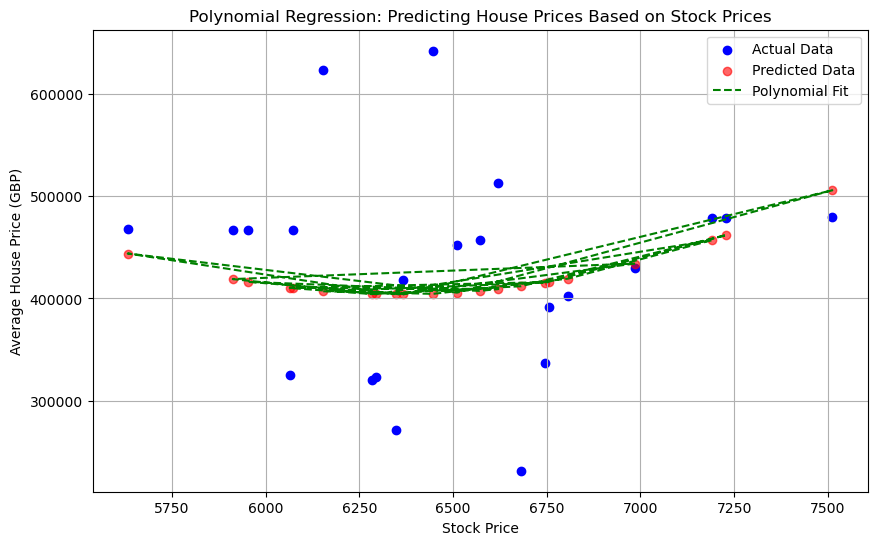

In [18]:
# Visualize the polynomial regression results
plt.figure(figsize=(10, 6))
plt.scatter(X_test_poly, y_test_poly, color='blue', label='Actual Data')
plt.scatter(X_test_poly, y_test_pred_poly, color='red', label='Predicted Data', alpha=0.6)
plt.plot(X_test_poly, y_test_pred_poly, color='green', linestyle='--', label='Polynomial Fit')
plt.title('Polynomial Regression: Predicting House Prices Based on Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Average House Price (GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Metrics: MSE={mse_rf:.2e}, RMSE={rmse_rf:.2e}, MAE={mae_rf:.2e}, R^2={r2_rf:.2f}")


Random Forest Metrics: MSE=9.83e+09, RMSE=9.91e+04, MAE=7.15e+04, R^2=0.34


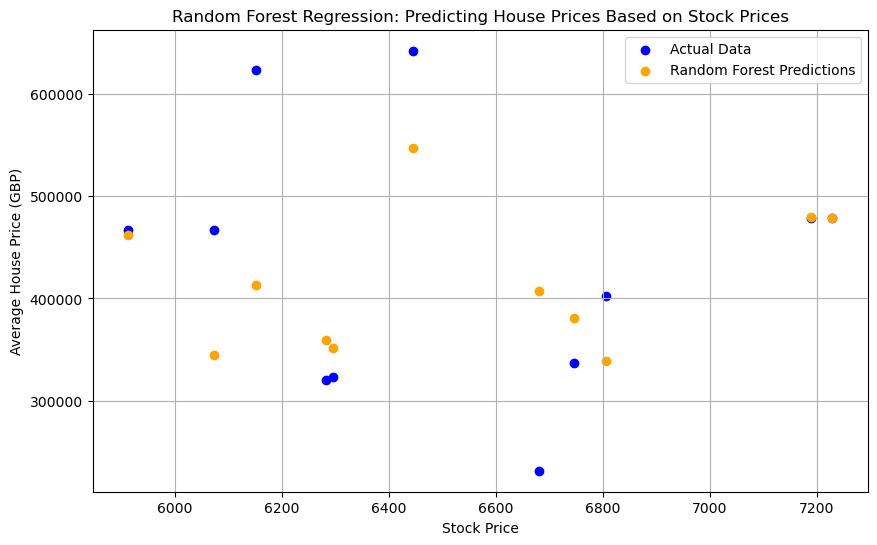

In [20]:
# Visualize Random Forest Results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_rf, color='orange', label='Random Forest Predictions')
plt.title('Random Forest Regression: Predicting House Prices Based on Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Average House Price (GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Support Vector Regression
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Metrics: MSE={mse_svr:.2e}, RMSE={rmse_svr:.2e}, MAE={mae_svr:.2e}, R^2={r2_svr:.2f}")


SVR Metrics: MSE=1.49e+10, RMSE=1.22e+05, MAE=1.02e+05, R^2=-0.01


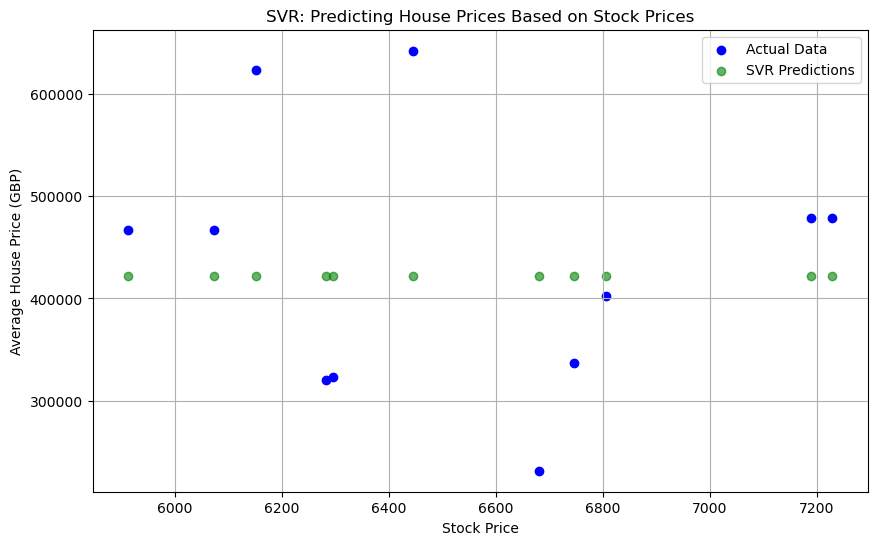

In [22]:
# Visualize SVR Results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_svr, color='green', alpha=0.6, label='SVR Predictions')
plt.title('SVR: Predicting House Prices Based on Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Average House Price (GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', max_iter=500, random_state=42)
nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluate Neural Network
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network Metrics: MSE={mse_nn:.2e}, RMSE={rmse_nn:.2e}, MAE={mae_nn:.2e}, R^2={r2_nn:.2f}")


Neural Network Metrics: MSE=2.01e+11, RMSE=4.49e+05, MAE=4.32e+05, R^2=-12.62


C:\Users\21366\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


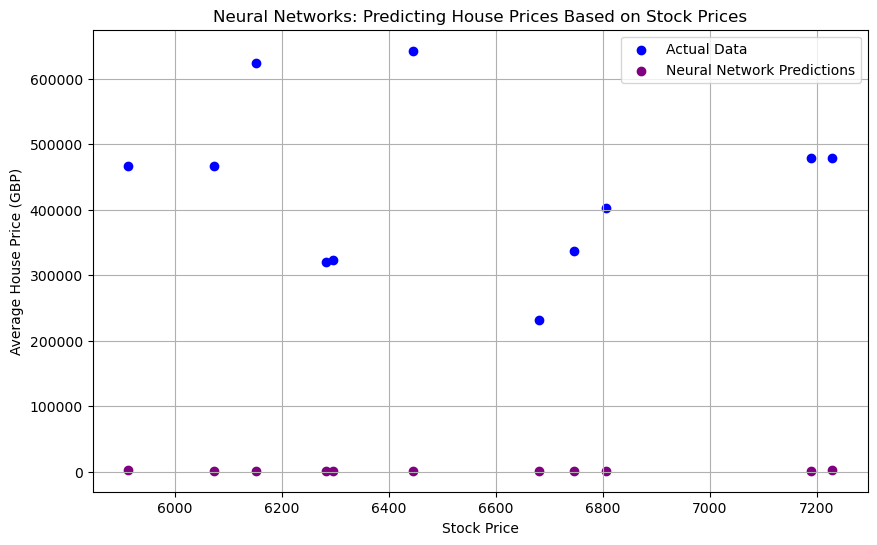

In [24]:
# Plot Training vs Validation Loss for Neural Network
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_nn, color='purple', label='Neural Network Predictions')
plt.title('Neural Networks: Predicting House Prices Based on Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Average House Price (GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Metrics: MSE={mse_xgb:.2e}, RMSE={rmse_xgb:.2e}, MAE={mae_xgb:.2e}, R^2={r2_xgb:.2f}")

XGBoost Metrics: MSE=9.76e+09, RMSE=9.88e+04, MAE=7.02e+04, R^2=0.34


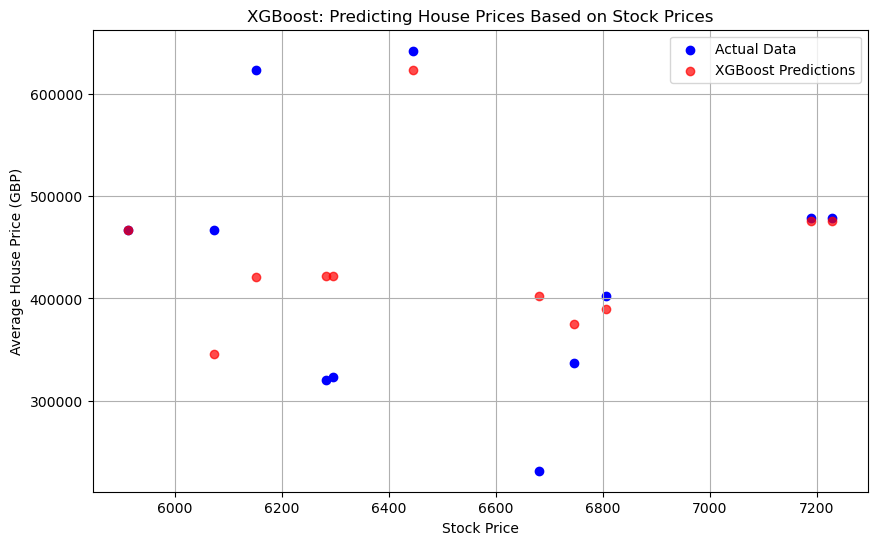

In [26]:
# Visualize XGBoost Results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_xgb, color='red', alpha=0.7, label='XGBoost Predictions')
plt.title('XGBoost: Predicting House Prices Based on Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Average House Price (GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Comparison of Results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'SVR', 'Neural Network', 'XGBoost'],
    'MSE': [mse_linear, mse_rf, mse_svr, mse_nn, mse_xgb],
    'RMSE': [rmse_linear, rmse_rf, rmse_svr, rmse_nn, rmse_xgb],
    'MAE': [mae_linear, mae_rf, mae_svr, mae_nn, mae_xgb],
    'R^2': [r2_linear, r2_rf, r2_svr, r2_nn, r2_xgb]
})

print("Summary of Model Performance:")
print(results)

Summary of Model Performance:
               Model           MSE           RMSE            MAE        R^2
0  Linear Regression  1.560754e+10  124930.123223  103107.214528  -0.055254
1      Random Forest  9.827708e+09   99134.794896   71478.849964   0.335531
2                SVR  1.493127e+10  122193.594578  102017.711154  -0.009531
3     Neural Network  2.013938e+11  448769.192450  431994.349538 -12.616605
4            XGBoost  9.758506e+09   98785.150568   70230.522500   0.340209


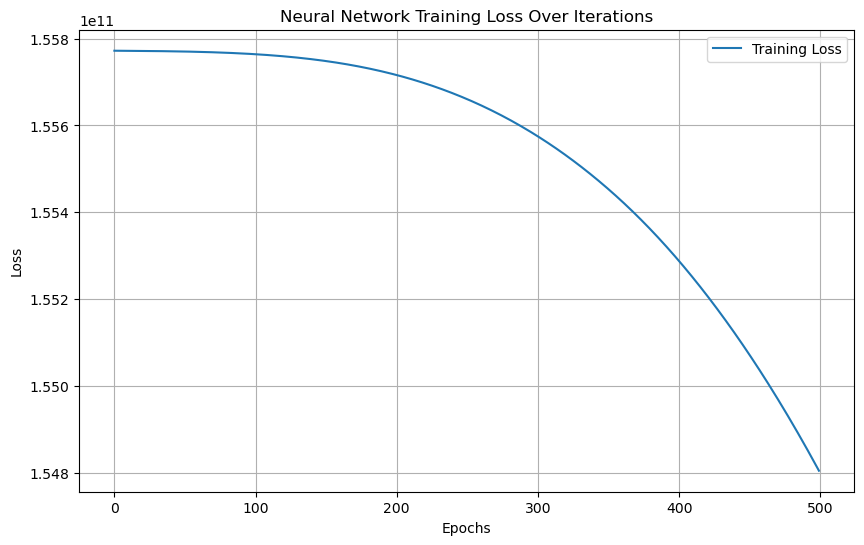

In [22]:
# Plotting Training Loss for Neural Network
plt.figure(figsize=(10, 6))
plt.plot(nn_model.loss_curve_, label='Training Loss')
plt.title('Neural Network Training Loss Over Iterations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()